# Inserting into Photometry, PhotometrySynced, and BehaviorIngestion

## Requirements before beginning: 

* dj_local_config.json: edited with appropriate information
* Your data directories are set up in the proper format under the O2 filesystem (please refer to documentation)
* You have created the appropriate .toml file to pair along with your photometry recordings (please refer to documentation)

In [1]:
import os
if os.path.basename(os.getcwd()) == "notebooks": os.chdir("..")
import datajoint as dj
dj.config.load('dj_local_config.json')
dj.conn()

from __future__ import annotations
import datajoint as dj
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import tomli
import tdt
import typing as T
from copy import deepcopy
import scipy.io as spio
from scipy import signal
from scipy.signal import blackman
from scipy.fft import fft, ifft, rfft

from element_interface.utils import find_full_path
from workflow import db_prefix
from workflow.pipeline import session, subject, lab, reference, ingestion, event, trial, photometry
from workflow.utils.paths import get_raw_root_data_dir
import workflow.utils.photometry_preprocessing as pp
from workflow.utils import demodulation

[2023-10-20 10:56:35,365][INFO]: Connecting jbw25@sabatini-dj-prd01.cluster-cjvmzxer50q5.us-east-1.rds.amazonaws.com:3306
[2023-10-20 10:56:35,692][INFO]: Connected jbw25@sabatini-dj-prd01.cluster-cjvmzxer50q5.us-east-1.rds.amazonaws.com:3306


## Insert subject, session, and session dir.

In [ ]:
subject.Subject.insert1(dict(subject='WS11', 
                             sex='F', 
                             subject_birth_date='2023-10-02', 
                             subject_description='HMS workshop mouse 11'))


In [ ]:
session_key = dict(subject = 'WS11', session_id=1, session_datetime = '2023-10-01 12:00:00')

#session.Session.insert1(session_key)

In [ ]:
#remember, your sessionDirectory is relative to the path in your config file!
session.SessionDirectory.insert1(dict(subject=session_key['subject'], session_id=session_key['session_id'],
                                      session_dir='Photometry/WS10/session1'))

In [ ]:
#view your subject, session_id, and session_dir
session.SessionDirectory()

## Populate your pipeline of choice

### For Photometry pipeline:

In [2]:
session_key = (session.Session() & "subject='WS1'").fetch1("KEY")

In [3]:
sd_key = dict(session_key, session_dir = r'WS1/session1')

In [ ]:
photometry.FiberPhotometry.populate(sd_key)

### For PhotometrySynced pipeline:

In [ ]:
photometry.FiberPhotometrySynced.populate(session_key)

### For Behavior pipeline:

In [ ]:
ingestion.BehaviorIngestion.populate(sd_key)

In [ ]:
ingestion.BehaviorIngestion()

#### We can now begin to fetch the data to view it. We'll start by first looking at the demodulated traces.

In [4]:
#Fetch one fiber
fiber_id = 1
photometry.FiberPhotometry.DemodulatedTrace & session_key & f"fiber_id = '{fiber_id}'"

subject,session_id,fiber_id,hemisphere,"trace_name (e.g., raw, detrend)",emission_color,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),carrier_frequency,demod_sample_rate sample rate of the demodulated data (in Hz),trace demodulated photometry traces
WS1,1,1,right,carrier,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,1,right,carrier,red,redGRABDA,560,223,223.0,=BLOB=
WS1,1,1,right,photom,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,1,right,photom,red,redGRABDA,560,223,223.0,=BLOB=


In [5]:
photometry.FiberPhotometry.DemodulatedTrace & session_key

subject,session_id,fiber_id,hemisphere,"trace_name (e.g., raw, detrend)",emission_color,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),carrier_frequency,demod_sample_rate sample rate of the demodulated data (in Hz),trace demodulated photometry traces
WS1,1,1,right,carrier,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,1,right,carrier,red,redGRABDA,560,223,223.0,=BLOB=
WS1,1,1,right,photom,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,1,right,photom,red,redGRABDA,560,223,223.0,=BLOB=
WS1,1,2,left,carrier,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,2,left,carrier,red,redGRABDA,560,223,223.0,=BLOB=
WS1,1,2,left,photom,green,dLight1.1,465,167,167.0,=BLOB=
WS1,1,2,left,photom,red,redGRABDA,560,223,223.0,=BLOB=


In [6]:
# Fetch photometry trace
trace_name = "photom"
emission_color = "green"
hemisphere = "right"

restr = {
         "trace_name": trace_name, 
         "emission_color": emission_color,
         "hemisphere": hemisphere
         }
query = photometry.FiberPhotometry.DemodulatedTrace() & session_key & restr
trace = query.fetch1("trace")
query

subject,session_id,fiber_id,hemisphere,"trace_name (e.g., raw, detrend)",emission_color,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),carrier_frequency,demod_sample_rate sample rate of the demodulated data (in Hz),trace demodulated photometry traces
WS1,1,1,right,photom,green,dLight1.1,465,167,167.0,=BLOB=


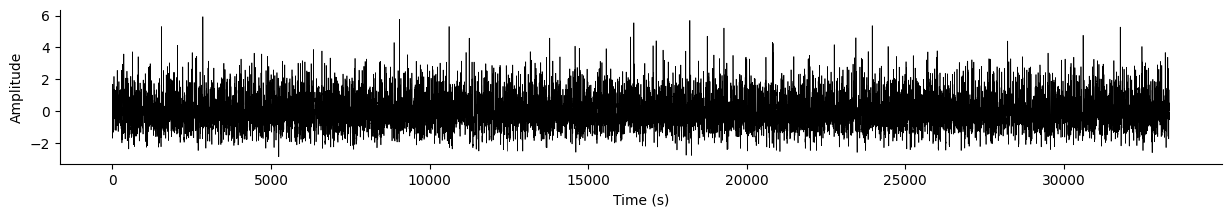

In [7]:
#Plot a single trace (demodulated)
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import sem

fig, ax = plt.subplots(figsize=(15,2))

ax.plot(trace, 'k', lw=0.5)
ax.set(xlabel='Time (s)', ylabel='Amplitude')
sns.despine()

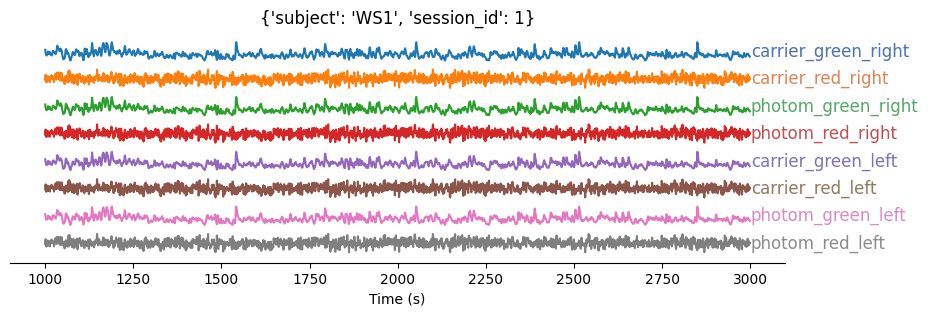

In [8]:
# Plot all phoeomtry traces during the session
query = photometry.FiberPhotometry.DemodulatedTrace & session_key
traces = query.fetch("trace_name", "emission_color", "hemisphere", "trace", as_dict=True)

i= 8
inc_height= -1.5
window_start = 1000 
window_stop = 3000
n_colors = len(query)
fig, ax = plt.subplots(figsize=(10, 3))
sns.set_palette('deep', n_colors)

for j, trace in enumerate(traces):
    name = '_'.join([trace["trace_name"], trace["emission_color"], trace["hemisphere"]])
    ax.plot(pp.normalize(pd.DataFrame(trace["trace"]), window=500)[window_start:window_stop] + i, 
            label=name)
    i += inc_height
    ax.text(x=window_stop + 2, y=i - inc_height, s=name, fontsize=12, va="bottom", color=sns.color_palette()[j])
    
ax.set_title(f"{session_key}")
ax.set_xlabel("Time (s)")
ax.set_yticks([])
sns.despine(left=True)

#### We can then take a look at the event-related photometry traces.

In [9]:
# view the names of your defined events
event.EventType & session_key

event_type,event_type_description
centerport,
centerport_end,
choice,
cue_end,
cue_start,
ENL_end,
ENL_start,
leftport,
leftport_end,
left_lick,


In [10]:
# Behavioral events during the session
event.Event & session_key

subject,session_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
WS1,1,centerport,0.972,nan
WS1,1,centerport,15.39,nan
WS1,1,centerport,20.79,nan
WS1,1,centerport,24.624,nan
WS1,1,centerport,29.214,nan
WS1,1,centerport,36.774,nan
WS1,1,centerport,42.606,nan
WS1,1,centerport,42.768,nan
WS1,1,centerport,43.092,nan
WS1,1,centerport,43.2,nan


In [11]:
#fetch your event types and/or call particular ones
event_types = (event.EventType & session_key).fetch("event_type")

In [12]:
# Plot peri-event photometry traces per hemisphere
trace_name = "photom"
emission_color = "red"

restr = {
    "trace_name": trace_name,
    "emission_color": emission_color,
    "hemisphere": "right"
}


time_buffer = (20, 60)  # before and after each event

trace = (photometry.FiberPhotometrySynced.SyncedTrace & session_key & restr).fetch1("trace")
timestamps = np.array((photometry.FiberPhotometrySynced & session_key).fetch1("timestamps"))

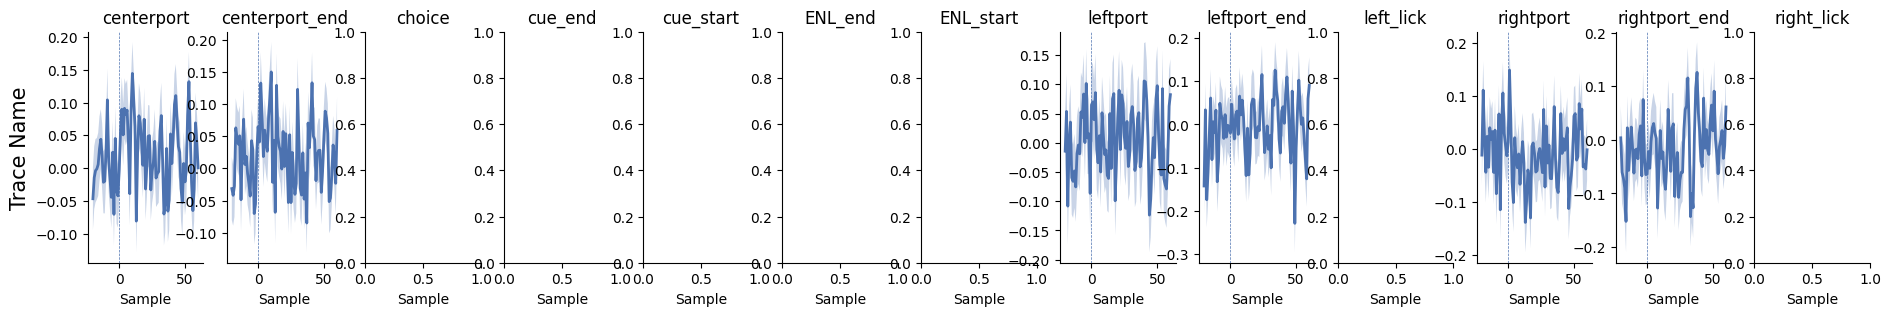

In [13]:
fig, axes = plt.subplots(1, len(event_types), figsize=(23, 3))
for ind, (event_type, ax) in enumerate(zip(event_types, axes)):

    event_traces = []  # Store traces for this event type

    desired_length = len(trace)
    new_timestamps = np.linspace(timestamps[0], timestamps[-1], desired_length)
    df = pd.DataFrame({"timestamps": new_timestamps, "photometry_trace": trace})

    # Query the event_start_time for the respective event type
    query = event.Event & session_key & f"event_type='{event_type}'"
    event_ts = query.fetch("event_start_time")

    # Iterate over each event time
    for ts in event_ts:
        # Find the corresponding index in the trace for the event time
        index = np.searchsorted(df["timestamps"], ts)

        # Define the time window around the event
        window_start = index - int(time_buffer[0])
        window_end = index + int(time_buffer[1]) + 1

        # Extract the peri-event window
        peri_event_window = df.iloc[window_start:window_end]

        if len(peri_event_window["photometry_trace"]) == len(range(window_start, window_end)):
            event_traces.append(peri_event_window["photometry_trace"].values)
        
    if event_traces:  # Check if there are event traces
        event_traces = np.array(event_traces)  # trial x time

        # Compute the mean and standard error of the event traces
        mean_trace = np.mean(event_traces, axis=0)
        sem_trace = sem(event_traces, axis=0)
        mean_trace_timestamps = np.arange(-time_buffer[0], time_buffer[1]+1)

        # Plot the mean trace with standard error
        ax.plot(mean_trace_timestamps, mean_trace, label=event_type, lw=2)
        ax.fill_between(mean_trace_timestamps, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3)

    ax.axvline(x=0, linewidth=0.5, ls='--')
    if ind == 0:
        ax.set_ylabel("Trace Name", fontsize=15)
    ax.set(xlabel='Sample', title=event_type)
    sns.despine()

plt.show()


In [14]:
def plot_event_aligned_photometry(trace_name, emission_color, hemisphere):
    restr = {
    "trace_name": trace_name,
    "emission_color": emission_color,
    "hemisphere": hemisphere
    }

    time_buffer = (20, 60)  # before and after each event

    trace = (photometry.FiberPhotometrySynced.SyncedTrace & session_key & restr).fetch1("trace")
    timestamps = np.array((photometry.FiberPhotometrySynced & session_key).fetch1("timestamps"))

    fig, axes = plt.subplots(1, len(event_types), figsize=(23, 3))

    for ind, (event_type, ax) in enumerate(zip(event_types, axes)):

        event_traces = []  # Store traces for this event type

        desired_length = len(trace)
        new_timestamps = np.linspace(timestamps[0], timestamps[-1], desired_length)
        df = pd.DataFrame({"timestamps": new_timestamps, "photometry_trace": trace})

        # Query the event_start_time for the respective event type
        query = event.Event & session_key & f"event_type='{event_type}'"
        event_ts = query.fetch("event_start_time")

        # Iterate over each event time
        for ts in event_ts:
            # Find the corresponding index in the trace for the event time
            index = np.searchsorted(df["timestamps"], ts)

            # Define the time window around the event
            window_start = index - int(time_buffer[0])
            window_end = index + int(time_buffer[1]) + 1

            # Extract the peri-event window
            peri_event_window = df.iloc[window_start:window_end]

            if len(peri_event_window["photometry_trace"]) == len(range(window_start, window_end)):
                event_traces.append(peri_event_window["photometry_trace"].values)
            
        if event_traces:  # Check if there are event traces
            event_traces = np.array(event_traces)  # trial x time

            # Compute the mean and standard error of the event traces
            mean_trace = np.mean(event_traces, axis=0)
            sem_trace = sem(event_traces, axis=0)
            mean_trace_timestamps = np.arange(-time_buffer[0], time_buffer[1]+1)

            # Plot the mean trace with standard error
            ax.plot(mean_trace_timestamps, mean_trace, label=event_type, lw=2)
            ax.fill_between(mean_trace_timestamps, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3)

        ax.axvline(x=0, linewidth=0.5, ls='--')
        if ind == 0:
            ax.set_ylabel("Trace Name", fontsize=15)
        ax.set(xlabel='Sample', title=event_type)
        sns.despine()

    return fig

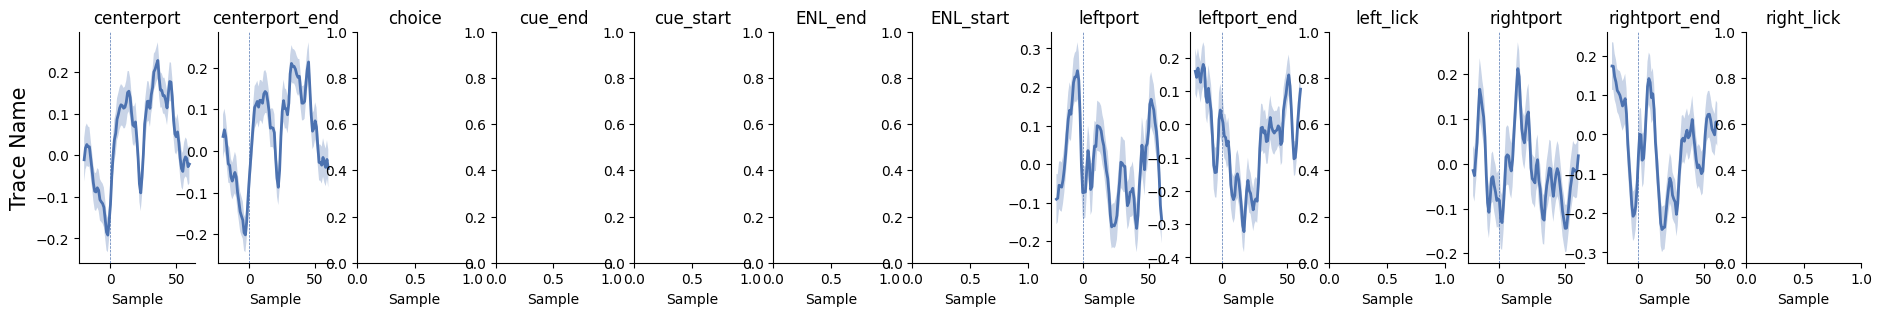

In [15]:
fig1 = plot_event_aligned_photometry("photom", "green", "right")